In [3]:
from portfolio_optimisation.classes.yahoo_parser import SP500Parser
yahoo_parser = SP500Parser()


start = '2010-01-01'
end = '2024-01-01'
data = yahoo_parser.download_sp500_data(start, end)

[*********************100%%**********************]  503 of 503 completed

2 Failed downloads:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2010-01-01 -> 2024-01-01)')


In [5]:
data.to_csv('/Users/sprilut/workspace/hse/Portfolio_Optimisation/datasets/sp500_historical_data.csv')

In [6]:
data.head()

,Symbol,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,,
2010-01-04,A,20.154915,22.389128,22.625179,22.267525,22.453505,3815561.0
2010-01-05,A,19.935982,22.145924,22.331903,22.002861,22.324751,4186031.0
2010-01-06,A,19.865147,22.067240,22.174536,22.002861,22.067240,3243779.0
2010-01-07,A,19.839396,22.038628,22.045780,21.816881,22.017166,3095172.0
2010-01-08,A,19.832952,22.031473,22.067240,21.745352,21.917025,3733918.0


In [48]:
import pandas as pd
data = pd.read_csv('/Users/sprilut/workspace/hse/Portfolio_Optimisation/datasets/sp500_historical_data.csv', index_col=0)
import pandas as pd
import numpy as np

hard_coded_portfolio = {
    'AAPL': 0.07,
    'MSFT': 0.065,
    'AMZN': 0.032,
    'NVDA': 0.028,
    'GOOGL': 0.021,
    'TSLA': 0.019,
    'GOOG': 0.018,
    'BRK.B': 0.018,
    'META': 0.018,
    'UNH': 0.013,
    'XOM': 0.013,
    'LLY': 0.012,
    'JPM': 0.012,
    'JNJ': 0.011,
    'V': 0.011,
    'PG': 0.01,
    'MA': 0.009,
    'AVGO': 0.009,
    'HD': 0.009,
    'CVX': 0.008,
    'MRK': 0.007,
    'ABBV': 0.007,
    'COST': 0.007,
    'PEP': 0.007,
    'ADBE': 0.007
}
best_25_tickers = list(hard_coded_portfolio.keys())
best_25_historical = data[data['Symbol'].isin(best_25_tickers)]

In [61]:
import pandas as pd
import pandas as pd
from ta.trend import MACD
# Assuming 'data' is your DataFrame and it includes a 'Close' column

# Assuming 'data' is your DataFrame and it includes 'StockID' and 'Close' columns
# First, ensure your MACD and RSI functions are defined

def apply_features(group):
    group.index = pd.to_datetime(group.index)

    # Compute lag features, moving averages, etc., for the group
    for lag in range(1, 4):
        group[f'lag_{lag}'] = group['Close'].shift(lag)
    group['weekly_return'] = group['Close'].pct_change(5)
    group['5_day_MA'] = group['Close'].rolling(window=5).mean()
    group['20_day_MA'] = group['Close'].rolling(window=20).mean()
    group['5_day_volatility'] = group['Close'].rolling(window=5).std()
    group['momentum'] = group['Close'] - group['Close'].shift(1)
    
    # MACD, ensuring you handle NaNs as per your strategy

    macd = MACD(close=group['Close'], window_slow=26, window_fast=12, window_sign=9)
    group['MACD'] = macd.macd()
    group['MACD_signal'] = macd.macd_signal()
    group['MACD_histogram'] = macd.macd_diff()

    # Adjusting for multi-stock data: adding week_of_year and month
    group['week_of_year'] = group.index.isocalendar().week
    group['month'] = group.index.month
    
    return group.dropna()  # Optionally drop NaNs

# Apply the function to each group and recombine
data_grouped = data.groupby('Symbol').apply(apply_features)


In [62]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Define the features and target variable
features = ['lag_1', 'lag_2', 'lag_3', '5_day_MA', '20_day_MA', '5_day_volatility', 'momentum', 'MACD', 'MACD_signal', 'MACD_histogram', 'week_of_year', 'month']
target = 'weekly_return'

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_grouped[features], data_grouped[target], test_size=0.2, random_state=42)

# Initialize the random forest regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Fit the model on the training data
rf.fit(X_train, y_train)

# Predict the target variable for the test data
y_pred = rf.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
mse

0.0005517693131571629

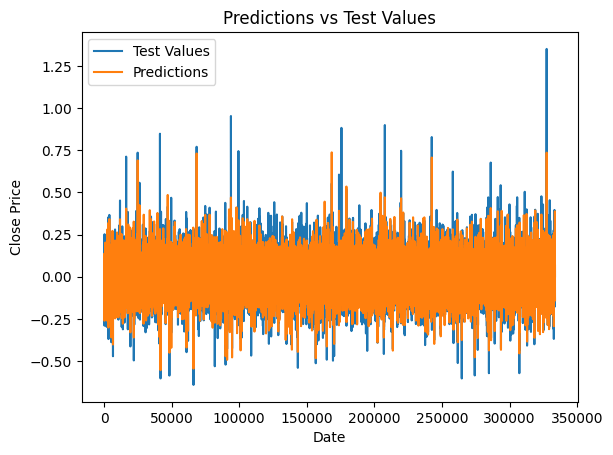

In [63]:
import matplotlib.pyplot as plt

# Plot the predictions and test values
plt.plot(y_test.values, label='Test Values')
plt.plot(y_pred, label='Predictions')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Predictions vs Test Values')
plt.legend()
plt.show()


In [64]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate mean absolute error
mae = mean_absolute_error(y_test, y_pred)

# Calculate root mean squared error
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Calculate R-squared score
r2 = r2_score(y_test, y_pred)


# Print the metrics
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)
print("R-squared Score:", r2)


Mean Absolute Error: 0.01581976134678701
Root Mean Squared Error: 0.02348977039387918
R-squared Score: 0.7064525583225032
